In [3]:
import scipy.io #initializes libraries

import time
import math
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [4]:
test2 = pd.read_csv('./test2.csv')
test2

,Cell,Cycle,C1ch_Mean_Charge,C1ch_Max_Charge,C1ch_Min_Charge,C1ch_Charge_Diff,C1ch_Mode_Charge,OCVch_Mean_Charge,OCVch_Max_Charge,OCVch_Min_Charge,...,C1dc_Mean_Charge,C1dc_Max_Charge,C1dc_Min_Charge,C1dc_Charge_Diff,C1dc_Mode_Charge,OCVdc_Mean_Charge,OCVdc_Max_Charge,OCVdc_Min_Charge,OCVdc_Charge_Diff,OCVdc_Mode_Charge
0,Cell1,cyc0000,362.101645,724.120891,-0.000049,0.206361,-0.000049,372.578478,744.988189,-0.000002,...,-369.627798,0,-739.110921,-0.204910,-739.110921,-369.958886,0,-739.819699,-0.053494,-739.819699
1,Cell1,cyc0100,357.357602,714.535043,-0.000049,0.206334,-0.000049,369.669968,739.178962,-0.000002,...,-365.173086,0,-730.192949,-0.204880,-730.192949,-367.436025,0,-734.758981,-0.053472,-734.758981
2,Cell1,cyc0200,354.941378,709.854347,-0.000049,0.206353,-0.000049,367.334726,734.620310,-0.000002,...,-362.981374,0,-725.746738,-0.204840,-725.746738,-365.663049,0,-731.319321,-0.053494,-731.319321
3,Cell1,cyc0300,353.572341,707.039348,-0.000049,0.206375,-0.000049,365.272572,730.326522,-0.000002,...,-361.506176,0,-722.843197,-0.204829,-722.843197,-363.430433,0,-726.827169,-0.053232,-726.827169
4,Cell1,cyc0400,351.183383,702.234286,-0.000049,0.206357,-0.000049,363.172165,726.269250,-0.000002,...,-359.210361,0,-718.366896,-0.204896,-718.366896,-361.982343,0,-723.937605,-0.053447,-723.937605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514,Cell8,cyc7700,266.393030,532.768358,-0.000041,0.205623,-0.000041,288.518815,576.990499,-0.000002,...,-281.509558,0,-562.967109,-0.205462,-562.967109,-287.257537,0,-574.471645,-0.055505,-574.471645
515,Cell8,cyc7800,266.286437,532.554724,-0.000041,0.205620,-0.000041,287.584220,575.111208,-0.000002,...,-281.395745,0,-562.600497,-0.205404,-562.600497,-286.510466,0,-572.982491,-0.055505,-572.982491
516,Cell8,cyc7900,265.460224,530.924624,-0.000041,0.205625,-0.000041,286.893472,573.768344,-0.000002,...,-280.579534,0,-561.111148,-0.205460,-561.111148,-285.823754,0,-571.643579,-0.055510,-571.643579
517,Cell8,cyc8000,263.424992,526.726858,-0.000041,0.205592,-0.000041,286.840249,573.629564,-0.000002,...,-279.134598,0,-558.161084,-0.205433,-558.161084,-285.463088,0,-570.896403,-0.055502,-570.896403


In [9]:
import torch
import torch.nn as nn

class GRUNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout=0.2):
        super(GRUNet, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # GRU 層
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        
        # 全連接層
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # 初始化隱藏狀態
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # (num_layers, batch_size, hidden_size)
        
        # GRU 前向傳播
        out, _ = self.gru(x, h0)  # out: (batch_size, sequence_length, hidden_size)
        
        # 取最後一個時間步的輸出
        out = out[:, -1, :]  # (batch_size, hidden_size)
        
        # 全連接層
        out = self.fc(out)  # (batch_size, output_size)
        return out

In [5]:
test2.keys()

Index(['Cell', 'Cycle', 'C1ch_Mean_Charge', 'C1ch_Max_Charge',
       'C1ch_Min_Charge', 'C1ch_Charge_Diff', 'C1ch_Mode_Charge',
       'OCVch_Mean_Charge', 'OCVch_Max_Charge', 'OCVch_Min_Charge',
       'OCVch_Charge_Diff', 'OCVch_Mode_Charge', 'C1dc_Mean_Charge',
       'C1dc_Max_Charge', 'C1dc_Min_Charge', 'C1dc_Charge_Diff',
       'C1dc_Mode_Charge', 'OCVdc_Mean_Charge', 'OCVdc_Max_Charge',
       'OCVdc_Min_Charge', 'OCVdc_Charge_Diff', 'OCVdc_Mode_Charge'],
      dtype='object')

In [6]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 讀取數據並準備
data = pd.read_csv('./test2.csv')

# 定義特徵和目標
TARGET_COLUMN = "C1ch_Mean_Charge"  # 替換為您的目標欄位
FEATURE_COLUMNS = data.columns.drop([TARGET_COLUMN, "Cell", "Cycle"])  # 排除無關欄位

# 提取特徵和目標
features = data[FEATURE_COLUMNS].values
target = data[TARGET_COLUMN].values

# 特徵縮放（正規化）
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

# 定義時間序列長度
SEQUENCE_LENGTH = 10

# 創建序列數據
def create_sequences(features, target, seq_length):
    X, y = [], []
    for i in range(len(features) - seq_length):
        X.append(features[i:i + seq_length])
        y.append(target[i + seq_length])
    return np.array(X), np.array(y)

X, y = create_sequences(features, target, SEQUENCE_LENGTH)

# 分割訓練、驗證與測試集
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 轉換為 PyTorch 張量
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [7]:
from torch.utils.data import DataLoader, TensorDataset

# 創建 DataLoader
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)


In [10]:
input_dim = X_train.shape[2]  # 特徵數
hidden_dim = 128  # 隱藏層大小
output_dim = 1  # 預測值輸出的維度
n_layers = 2  # GRU/LSTM 層數

# 初始化模型
gru_model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
lstm_model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)

# 設定損失函數與優化器
criterion = nn.MSELoss()
gru_optimizer = torch.optim.Adam(gru_model.parameters(), lr=0.01)
lstm_optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01)

# 訓練 GRU 模型
train_model(gru_model, train_loader, val_loader, criterion, gru_optimizer, epochs=100)

# 訓練 LSTM 模型
train_model(lstm_model, train_loader, val_loader, criterion, lstm_optimizer, epochs=100)

NameError: name 'LSTMNet' is not defined

In [23]:
def evaluate_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(labels.cpu().numpy())
    return predictions, actuals

# 評估 GRU 模型
gru_predictions, gru_actuals = evaluate_model(gru_model, test_loader)

# 評估 LSTM 模型
lstm_predictions, lstm_actuals = evaluate_model(lstm_model, test_loader)

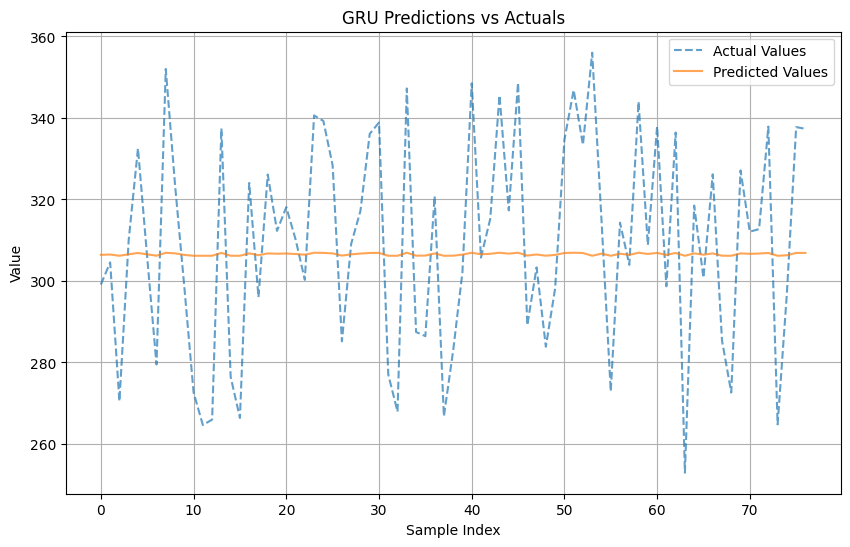

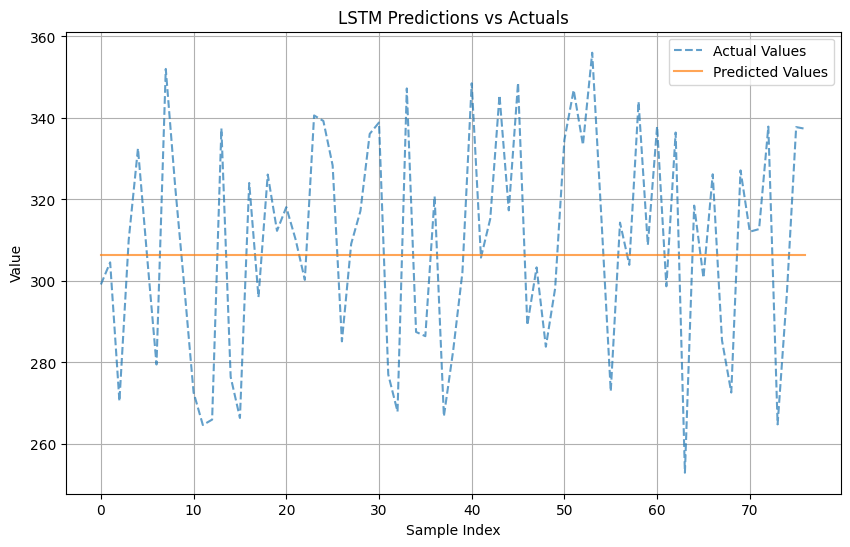

In [24]:
import matplotlib.pyplot as plt

# 繪製模型預測與實際值的比較
def plot_predictions(actuals, predictions, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(actuals, label="Actual Values", linestyle="--", alpha=0.7)
    plt.plot(predictions, label="Predicted Values", alpha=0.7)
    plt.title(f"{model_name} Predictions vs Actuals")
    plt.xlabel("Sample Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

# 使用 GRU 模型的結果繪圖
plot_predictions(gru_actuals, gru_predictions, "GRU")

# 使用 LSTM 模型的結果繪圖
plot_predictions(lstm_actuals, lstm_predictions, "LSTM")